In [516]:
%matplotlib inline
import matplotlib as lib
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
import numpy as np

In [517]:
video_views=pd.read_csv('video_views.csv')
problem=pd.read_csv('problems.csv')
problem_attemp=pd.read_csv('problem_attempts.csv')
video=pd.read_csv('videos.csv')

In [518]:
video_views.head()
# video_views['video_id']=video_views['video_id'].map(lambda x:x.replace('v','p'))
# video_views.head()

,student_id,section,subsection,video_id,date_viewed,duration_seconds,watched_seconds
0,0,Week 1,Lecture 1,lec1_v0,2018-09-25,389,272
1,0,Week 1,Lecture 1,lec1_v1,2018-09-25,564,164
2,0,Week 1,Lecture 1,lec1_v2,2018-09-17,343,93
3,0,Week 1,Lecture 1,lec1_v3,2018-09-28,364,358
4,0,Week 1,Lecture 1,lec1_v4,2018-10-19,402,229


In [519]:
problem_attemp.head()

,student_id,section,subsection,problem_id,date_attempted,max_points,score
0,0,Week 1,Lecture 1,lec1_p0,2018-09-30,1,1
1,0,Week 1,Lecture 1,lec1_p1,2018-09-30,1,1
2,0,Week 1,Lecture 1,lec1_p2,2018-11-18,1,0
3,0,Week 1,Lecture 1,lec1_p3,2018-09-30,1,1
4,0,Week 1,Lecture 1,lec1_p8,2018-10-31,1,1


In [520]:
problem=problem.rename(columns={'id':'problem_id'})
problem.head()

,problem_id,section,subsection,max_points
0,lec1_p0,Week 1,Lecture 1,1
1,lec1_p1,Week 1,Lecture 1,1
2,lec1_p2,Week 1,Lecture 1,1
3,lec1_p3,Week 1,Lecture 1,1
4,lec1_p4,Week 1,Lecture 1,1


In [521]:
video.head()
# video['id']=video['id'].map(lambda x:x.replace('v','p'))
# video.head()

,id,section,subsection,duration_seconds
0,lec1_v0,Week 1,Lecture 1,389
1,lec1_v1,Week 1,Lecture 1,564
2,lec1_v2,Week 1,Lecture 1,343
3,lec1_v3,Week 1,Lecture 1,364
4,lec1_v4,Week 1,Lecture 1,402


In [522]:
x=problem.groupby(['subsection','section']).sum()
x=x.reset_index()
x=x.rename(columns={'max_points':'max_points_lecture'})
# problemMP=pd.merge(x,problem,right_on='subsection',left_on='subsection')
# problemMP.head()
x.head()

,subsection,section,max_points_lecture
0,Lecture 1,Week 1,9
1,Lecture 10,Week 5,7
2,Lecture 11,Week 6,10
3,Lecture 12,Week 6,5
4,Lecture 13,Week 7,7


In [523]:
y=problem_attemp.groupby(['student_id','section','subsection']).sum()
y=y.reset_index()
y=y.rename(columns={'score':'StudentScore'})
y.head()

,student_id,section,subsection,max_points,StudentScore
0,0,Week 1,Lecture 1,5,4
1,0,Week 1,Lecture 2,1,1
2,0,Week 2,Lecture 3,1,1
3,1,Week 1,Lecture 1,4,2
4,1,Week 1,Lecture 2,1,1


In [524]:
y=y.drop('max_points',1)

In [525]:
score=pd.merge(x,y,left_on=['subsection','section'],right_on=['subsection','section'],how='outer')
score.head()

,subsection,section,max_points_lecture,student_id,StudentScore
0,Lecture 1,Week 1,9,0,4
1,Lecture 1,Week 1,9,1,2
2,Lecture 1,Week 1,9,2,1
3,Lecture 1,Week 1,9,3,0
4,Lecture 1,Week 1,9,5,1


In [526]:
#assuming that to pass a week, the student score has to be above 75%. We will see if students pass some weeks
def passFail(row):
    if row['StudentScore']/row['maxPointsWeek']>=.5:
        return "P"
    else:
        return "F"
# score['P/F']=score.apply(passFail,axis=1)
# score.sort_values('student_id').head()

In [527]:
# temp=score.groupby(['student_id']).max()
# temp=temp.reset_index()
# temp.rename(columns={'section':'noWeeks'},inplace=True)
# pf=pd.merge(score,temp[['student_id','noWeeks']],left_on='student_id',right_on='student_id')
# pf.sort_values('student_id',ascending=True).head()

There are 8 weeks and each week has at least 1 lectures. We will see how students doing, whether they fail or pass or complete the course. Maybe draft the number of weeks people complete?

In [528]:
# pf.groupby(['noWeeks']).agg({
#         'student_id':pd.Series.nunique,
#          'max_points_lecture':np.sum,
#         'TotalCharges':np.sum
#     })

In [529]:
temp=score.groupby(['student_id']).agg({
        'section':np.max,
        'max_points_lecture':np.sum,
        'StudentScore':np.sum
})
temp.rename(columns={'studentScore':'studentScoreWeeks','max_points_lecture':'maxPointsWeek','section':'weekFinished'},inplace=True)
temp=temp.reset_index()
temp['PorF']=temp.apply(passFail,axis=1)
noStudents=len(temp)

In [530]:
temp.head()

,student_id,StudentScore,maxPointsWeek,weekFinished,PorF
0,0,6,22,Week 2,F
1,1,4,22,Week 2,F
2,2,1,9,Week 1,F
3,3,0,9,Week 1,F
4,5,1,9,Week 1,F


In [531]:
weeks=temp.groupby(['weekFinished','PorF']).count()['student_id']
weeks.rename(columns={'student_id':'students'},inplace=True)
weeks=weeks.reset_index()
weeks.rename(columns={0:'countPF'},inplace=True)
weeks

,weekFinished,PorF,countPF
0,Week 1,F,210
1,Week 1,P,2
2,Week 2,F,43
3,Week 3,F,1
4,Week 5,P,1
5,Week 6,F,5
6,Week 7,F,1
7,Week 7,P,2
8,Week 8,F,9
9,Week 8,P,23


In [532]:
x=weeks.groupby('weekFinished').sum()
x=x.reset_index()
x['%week']=x['countPF']/x['countPF'].sum()
x.rename(columns={'countPF':'count'},inplace=True)
x

,weekFinished,count,%week
0,Week 1,212,0.713805
1,Week 2,43,0.144781
2,Week 3,1,0.003367
3,Week 5,1,0.003367
4,Week 6,5,0.016835
5,Week 7,3,0.010101
6,Week 8,32,0.107744


In [533]:
weeks=pd.merge(weeks,x,left_on='weekFinished',right_on='weekFinished')
weeks['%PF']=weeks['countPF']/weeks['count']


In [534]:
weeks['%PFw']=weeks['%PF']*weeks['%week']
weeks

,weekFinished,PorF,countPF,count,%week,%PF,%PFw
0,Week 1,F,210,212,0.713805,0.990566,0.707071
1,Week 1,P,2,212,0.713805,0.009434,0.006734
2,Week 2,F,43,43,0.144781,1.000000,0.144781
3,Week 3,F,1,1,0.003367,1.000000,0.003367
4,Week 5,P,1,1,0.003367,1.000000,0.003367
5,Week 6,F,5,5,0.016835,1.000000,0.016835
6,Week 7,F,1,3,0.010101,0.333333,0.003367
7,Week 7,P,2,3,0.010101,0.666667,0.006734
8,Week 8,F,9,32,0.107744,0.281250,0.030303
9,Week 8,P,23,32,0.107744,0.718750,0.077441


In [535]:
import seaborn as sns
import matplotlib.pyplot as plt

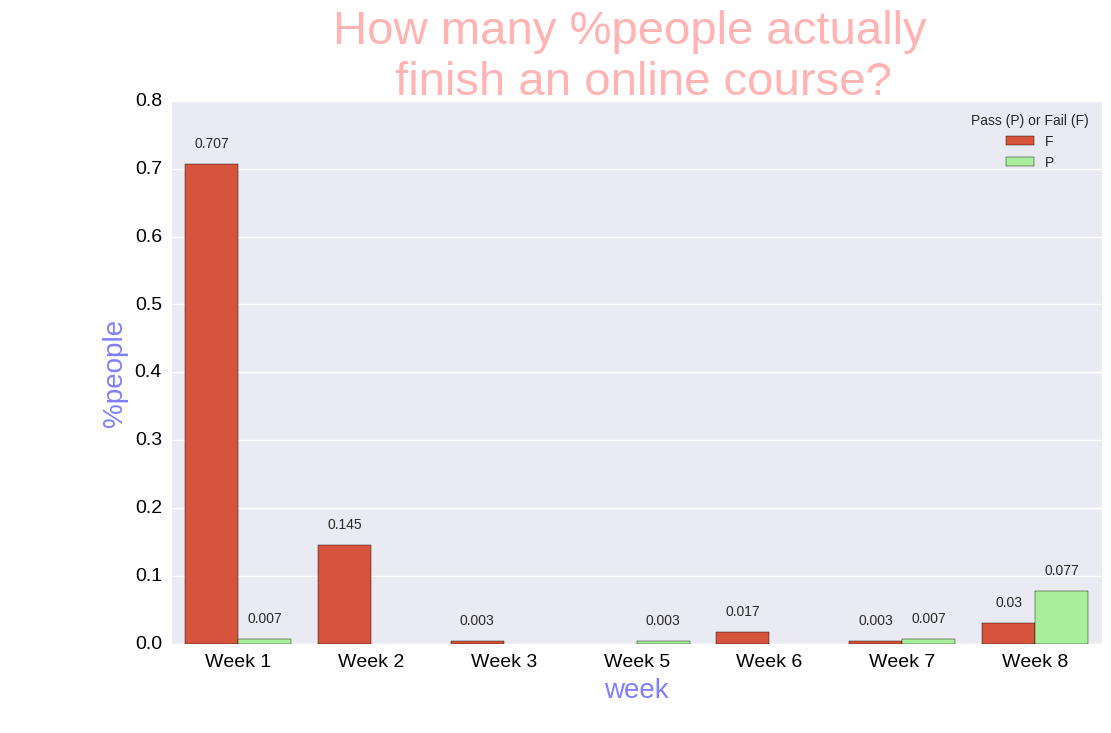

In [536]:
flatui = ["#ef4321",'#9ffc8d']
g=sns.barplot(x='weekFinished',y='%PFw',hue="PorF",data=weeks,palette=sns.color_palette(flatui),ci=None)

# remove the top and right line in graph
sns.despine()

# Set the size of the graph from here
g.figure.set_size_inches(12,7)
# Set the Title of the graph from here
g.axes.set_title('How many %people actually \n finish an online course?', 
    fontsize=34,color="r",alpha=0.3)
# Set the xlabel of the graph from here
g.set_xlabel("week",size = 20,color="b",alpha=0.5)
# Set the ylabel of the graph from here
g.set_ylabel("%people",size =20,color="b",alpha=0.5)
#Set the legend
g.legend(title= 'Pass (P) or Fail (F)',loc='upper right')
# Set the ticklabel size and color of the graph from here
g.tick_params(labelsize=14,labelcolor="black")
for p in g.patches:
    g.annotate(np.round(p.get_height(),decimals=3), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 15), textcoords='offset points')

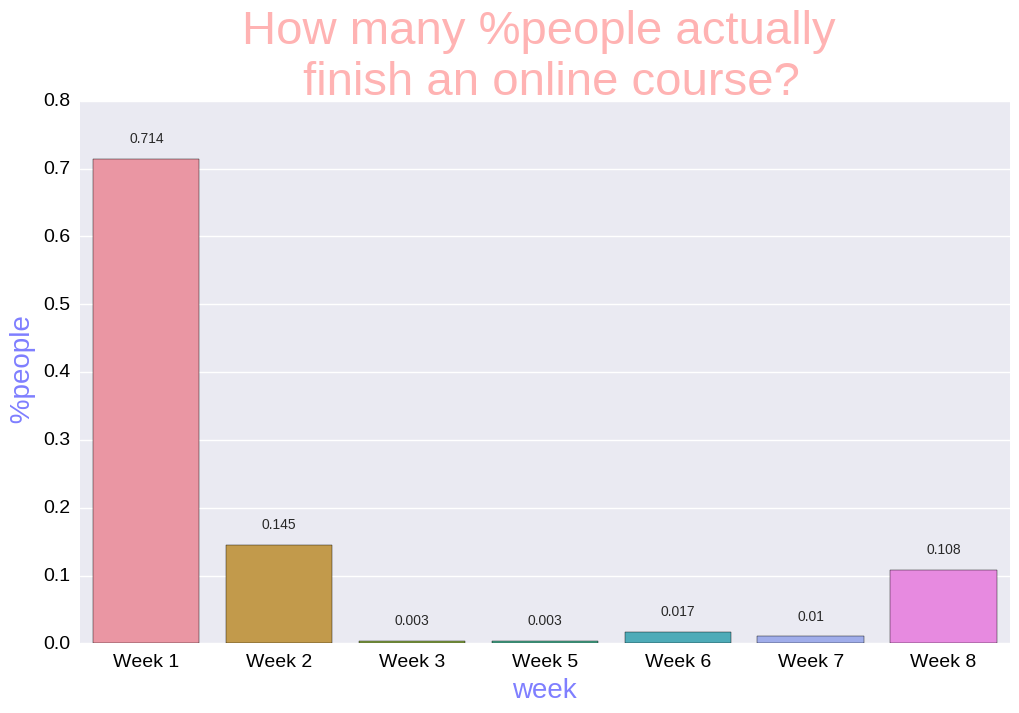

In [537]:
g2=sns.barplot(x='weekFinished',y='%week',data=weeks,ci=None)

# remove the top and right line in graph
sns.despine()

# Set the size of the graph from here
g2.figure.set_size_inches(12,7)
# Set the Title of the graph from here
g2.axes.set_title('How many %people actually \n finish an online course?', 
    fontsize=34,color="r",alpha=0.3)
# Set the xlabel of the graph from here
g2.set_xlabel("week",size = 20,color="b",alpha=0.5)
# Set the ylabel of the graph from here
g2.set_ylabel(" %people",size = 20,color="b",alpha=0.5)
#Set the le
#g2.legend(title= 'Pass (P) or Fail (F)',loc='upper right')
# Set the ticklabel size and color of the graph from here
g2.tick_params(labelsize=14,labelcolor="black")
for p in g2.patches:
    g2.annotate(np.round(p.get_height(),decimals=3), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 15), textcoords='offset points')

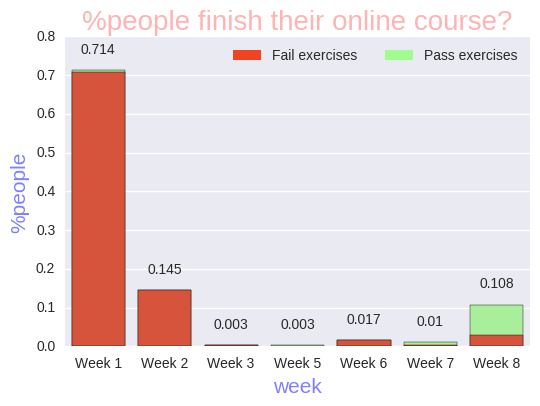

In [538]:
g.figure.set_size_inches(12,7)
#Plot 1 - background - "total" (top) series
g=sns.barplot(x ='weekFinished', y = '%week', data=weeks,color='#9ffc8d')
for p in g.patches:
    g.annotate(np.round(p.get_height(),decimals=3), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 15), textcoords='offset points')

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x ='weekFinished', y = weeks[weeks.PorF=='F']['%PFw'],data=weeks, color = "#ef4321")


topbar = plt.Rectangle((0,0),1,1,fc='#9ffc8d', edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#ef4321',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Fail exercises', 'Pass exercises'], loc=1, ncol = 2, prop={'size':10})
l.draw_frame(False)

g.axes.set_title('%people finish their online course?', 
    fontsize=20,color="r",alpha=0.3)
# Set the xlabel of the graph from here
g.set_xlabel("week",size = 15,color="b",alpha=0.5)
# Set the ylabel of the graph from here
g.set_ylabel("%people",size = 15,color="b",alpha=0.5)

fig = g.get_figure()
fig.savefig('output.png') 


In [542]:
weeks

,weekFinished,PorF,countPF,count,%week,%PF,%PFw
0,Week 1,F,210,212,0.713805,0.990566,0.707071
1,Week 1,P,2,212,0.713805,0.009434,0.006734
2,Week 2,F,43,43,0.144781,1.000000,0.144781
3,Week 3,F,1,1,0.003367,1.000000,0.003367
4,Week 5,P,1,1,0.003367,1.000000,0.003367
5,Week 6,F,5,5,0.016835,1.000000,0.016835
6,Week 7,F,1,3,0.010101,0.333333,0.003367
7,Week 7,P,2,3,0.010101,0.666667,0.006734
8,Week 8,F,9,32,0.107744,0.281250,0.030303
9,Week 8,P,23,32,0.107744,0.718750,0.077441


In [584]:
x=weeks[weeks.PorF=='P']
for i in range(1,9):
    if str(i) not in '.'.join(x.weekFinished.tolist()):
        x=x.append({'weekFinished':'Week '+str(i),'PorF':'P','%PFw':0},ignore_index=True)
x=x.sort_values('weekFinished')
x

,weekFinished,PorF,countPF,count,%week,%PF,%PFw
0,Week 1,P,2.0,212.0,0.713805,0.009434,0.006734
4,Week 2,P,NaN,NaN,NaN,NaN,0.000000
5,Week 3,P,NaN,NaN,NaN,NaN,0.000000
6,Week 4,P,NaN,NaN,NaN,NaN,0.000000
1,Week 5,P,1.0,1.0,0.003367,1.000000,0.003367
7,Week 6,P,NaN,NaN,NaN,NaN,0.000000
2,Week 7,P,2.0,3.0,0.010101,0.666667,0.006734
3,Week 8,P,23.0,32.0,0.107744,0.718750,0.077441


In [581]:
y=weeks[weeks.PorF=='F']
for i in range(1,9):
    if str(i) not in '.'.join(x.weekFinished.tolist()):
        y=y.append({'weekFinished':'Week '+str(i),'PorF':'F','%PFw':0},ignore_index=True)
y

,weekFinished,PorF,countPF,count,%week,%PF,%PFw
0,Week 1,F,210,212,0.713805,0.990566,0.707071
2,Week 2,F,43,43,0.144781,1.000000,0.144781
3,Week 3,F,1,1,0.003367,1.000000,0.003367
5,Week 6,F,5,5,0.016835,1.000000,0.016835
6,Week 7,F,1,3,0.010101,0.333333,0.003367
8,Week 8,F,9,32,0.107744,0.281250,0.030303


In [585]:
import plotly.plotly as py
py.sign_in('nguyli03', '31jlkx7yjq')
import plotly.graph_objs as go

trace1 = go.Bar(
    x=x['weekFinished'],
    y=x['%PFw'],
    name='pass'
)
trace2 = go.Bar(
    x=y['weekFinished'],
    y=y['%PFw'],
    name='fail'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data,layout=layout)
py.iplot(fig, filename='stacked-bar')
